In [1]:
#the file will load the parking data obtained from the Santa Monica website into an SQL file. Data will then be sorted and
#saved
import sqlite3
import os
import csv
import datetime
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import pickle

In [2]:
os.chdir('C:\\Users\\teek2\\Documents\\Parking_Data_Files')

connection = sqlite3.connect("SM_Main_Market.db")
cursor = connection.cursor()

try:
    cursor.execute("""DROP TABLE SM_Market_Data;""")
except:
    pass
     

"""Here we create the master SQL table that we will store all relevant
serving statistics in"""

sql_command = """
CREATE TABLE SM_Market_Data ( 
DATE CHAR(4), 
LOT_NAME CHAR(4),
ADDRESS CHAR(4),
LATITUDE FLOAT, 
LONGITUDE FLOAT, 
AVAILABLE INTEGER,
YEAR INTEGER,
DAY INTEGER,
MONTH INTEGER,
WEEKDAY INTEGER,
YMD CHAR(4));"""

cursor.execute(sql_command)
dataFiles = []
dataFolder='C:\\Users\\teek2\\Documents\\Farmers Market Forecast'

firstline=False

with open('Parking_Lot_Counts.csv') as csv_file:
    csv_reader=csv.reader(csv_file,delimiter=',')
    for row in csv_reader:
        
        if firstline==False:
            firstline=True
            continue
        else:
            try:
                trial=row
                date=row[0]
                date_instance=datetime.datetime.strptime(date, '%m/%d/%Y %I:%M:%S %p')
                
                name=row[1]
                address=row[3]
                longitude=float(row[5])
                latitude=float(row[6])
                available=int(row[7])
                year=date_instance.year
                month=date_instance.month
                day_of_month=date_instance.day
                day=date_instance.weekday()
                YMD=str(day_of_month)+"-"+str(month)+'-'+str(year)
                
            except ValueError:
                continue
                
        cursor.execute(""" INSERT INTO SM_Market_Data \
                        (DATE, LOT_NAME, ADDRESS, LATITUDE, LONGITUDE, AVAILABLE, YEAR, DAY, MONTH, WEEKDAY, YMD) \
                                VALUES(?,?,?,?,?,?,?,?,?,?,?)""" , \
                                (date,name,address,longitude,latitude,available,year,day_of_month,month,day,YMD))

    connection.commit()

In [2]:
conn = sqlite3.connect("SM_Main_Market.db")

SQL_Query = pd.read_sql_query(
'''SELECT *
FROM SM_Market_Data''', conn)

df_all_SM = pd.DataFrame(SQL_Query, columns=['DATE', 'LOT_NAME', 'ADDRESS', 'LATITUDE', 'LONGITUDE', 'AVAILABLE', 'YEAR', 'DAY', 'MONTH', 'WEEKDAY', 'YMD'])

In [3]:
df_all_SM['datetime']=df_all_SM['DATE'].apply(lambda x: datetime.datetime.strptime(x,'%m/%d/%Y %I:%M:%S %p'))

In [53]:
#select which public lots I want to monitor
#thesea are the ones in the downtown area

lots_to_keep=['Structure 5','Structure 1','Lot 4 South','Structure 2','Structure 3','Structure 6','Structure 8','Structure 9','Structure 7']
daily_parking_data=df_all_SM[df_all_SM['LOT_NAME'].apply(lambda x: x in lots_to_keep)]


#function that take a datestring and converts it to a datetime.date object


def YMD_to_dt(timestamp):
    time_parse=timestamp.split('-')
    return datetime.date(int(time_parse[-1]),int(time_parse[1]),int(time_parse[0]))


daily_parking_data['Datetime']=pd.to_datetime(daily_parking_data['YMD'].apply(lambda x: YMD_to_dt(x)))

#summed_data=daily_parking_data.groupby(by=['YMD']).sum()['AVAILABLE'].reset_index()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [54]:
#look at the parking in the peak hours
peak_parking_av=daily_parking_data[daily_parking_data['datetime'].apply(lambda x: True if x.hour>=9 and x.hour<=20 else False)].groupby(by=['YMD']).mean()['AVAILABLE'].reset_index()

In [55]:
#look at morning hour parking
morning_parking_av=daily_parking_data[daily_parking_data['datetime'].apply(lambda x: True if x.hour>=2 and x.hour<=9 else False)].groupby(by=['YMD']).mean()['AVAILABLE'].reset_index()

In [56]:
morning_parking_av=morning_parking_av.rename(columns={"YMD": "YMD", "AVAILABLE": "TAKEN"})

In [57]:
joined_parking_df=peak_parking_av.set_index('YMD').join(morning_parking_av.set_index('YMD'),lsuffix='YMD',rsuffix='YMD').reset_index().sort_values(by='YMD')

In [59]:
#hard-coding the baseline that is subtracted off so I can reuse value in other notebooks as data input changes

joined_parking_df['NET PEAK SPOTS']=joined_parking_df['AVAILABLE']-joined_parking_df['TAKEN']
joined_parking_df['NET PEAK SPOTS']=joined_parking_df['NET PEAK SPOTS']+245
joined_parking_df=joined_parking_df[['YMD','NET PEAK SPOTS']].sort_values(by=['YMD'])

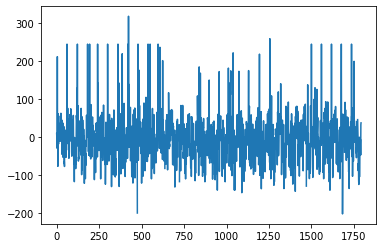

In [60]:
plt.figure()
plt.plot(joined_parking_df['NET PEAK SPOTS'])

In [49]:
joined_parking_df['Datetime']=joined_parking_df['YMD'].apply(lambda x: YMD_to_dt(x))

In [50]:
#export data file with daily parking info
os.chdir('C:\\Users\\teek2\\Documents\\Farmers Market Forecast\\Feature_Data_Files')
joined_parking_df[['Datetime','NET PEAK SPOTS']].to_pickle('Daily_SM_Parking.pkl')